<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB
None


In [164]:
df.isnull().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

In [165]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [166]:
def ml_model_glass(df_base, model, clip=False):
    X = df_base.drop(columns=["Type"])
    y = df_base["Type"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    if clip:
        for col in X_train.columns:
            lower = X_train[col].quantile(0.01)
            upper = X_train[col].quantile(0.99)
            X_train[col] = X_train[col].clip(lower=lower, upper=upper)
            X_test[col] = X_test[col].clip(lower=lower, upper=upper)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return print("Accuracy score:", round(acc, 5))

In [167]:
rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)
ml_model_glass(df, rfc_model)

Accuracy score: 0.83721


<Figure size 1000x600 with 0 Axes>

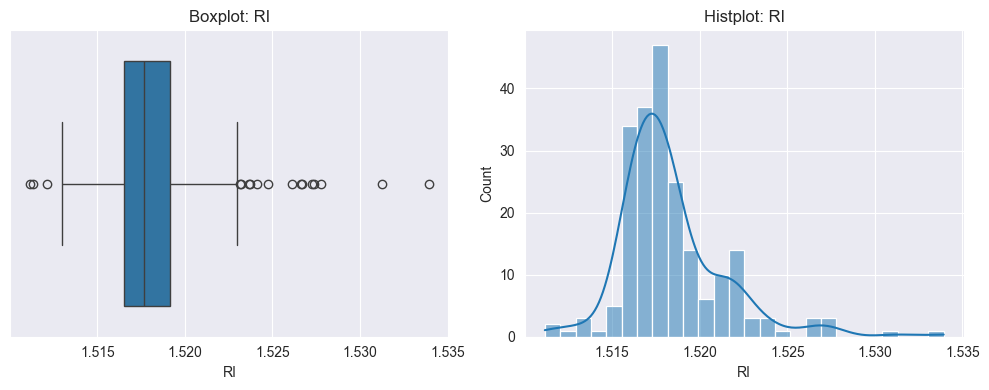

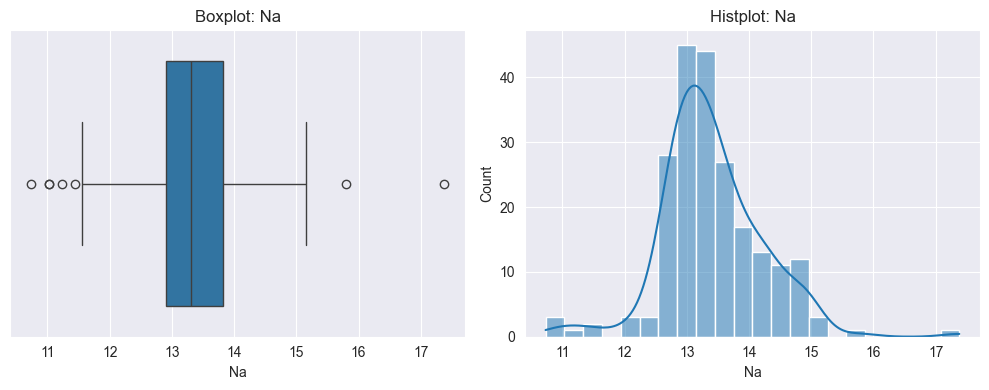

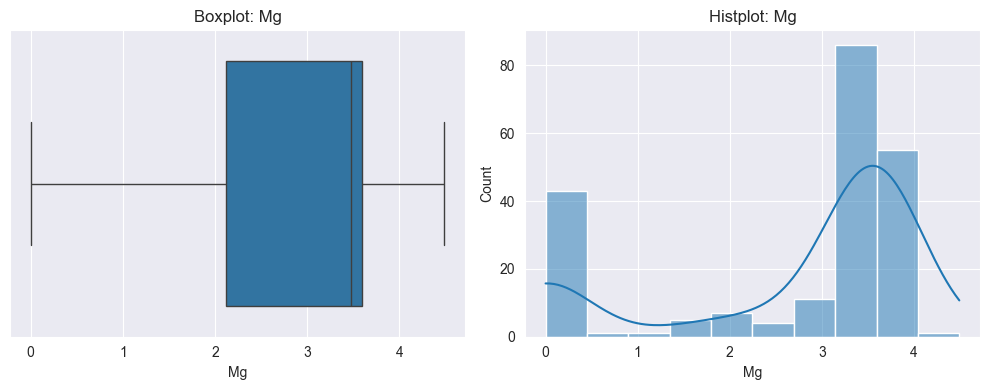

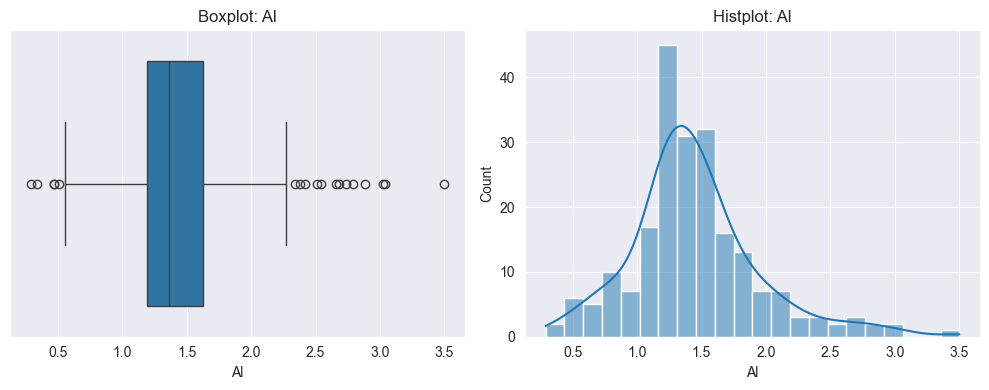

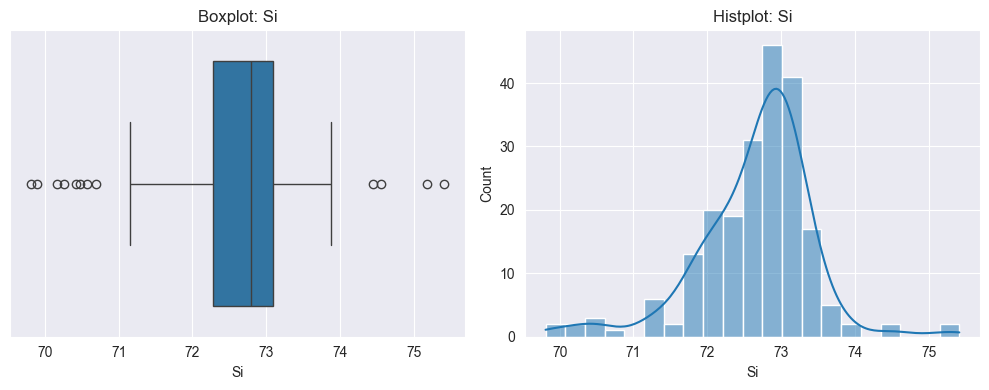

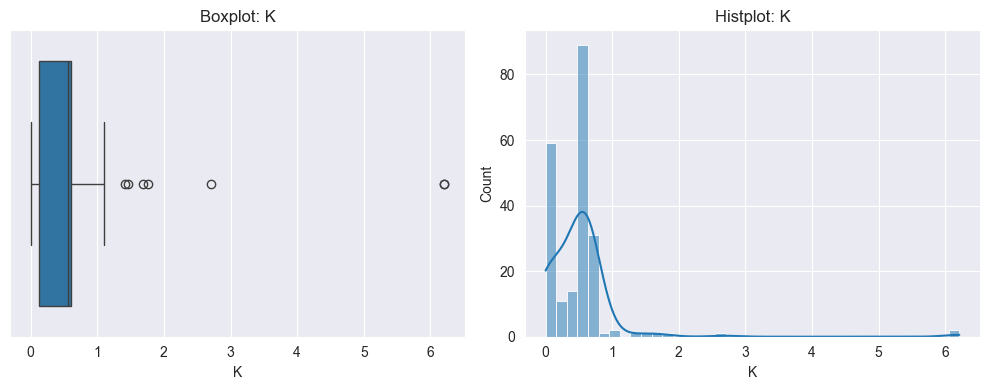

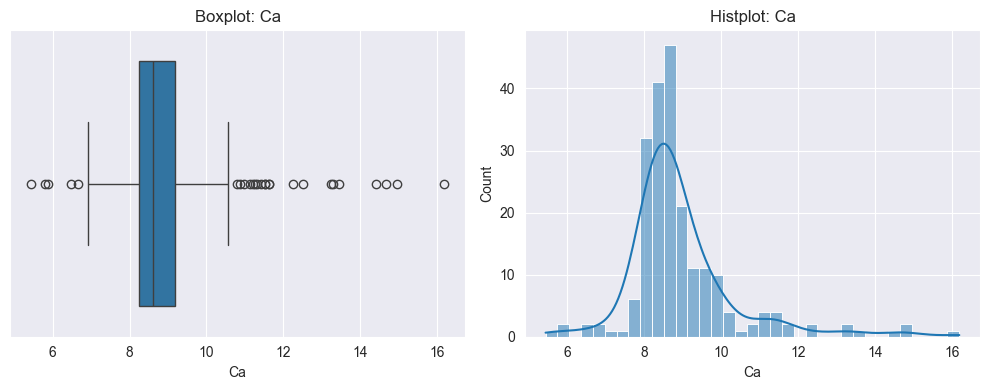

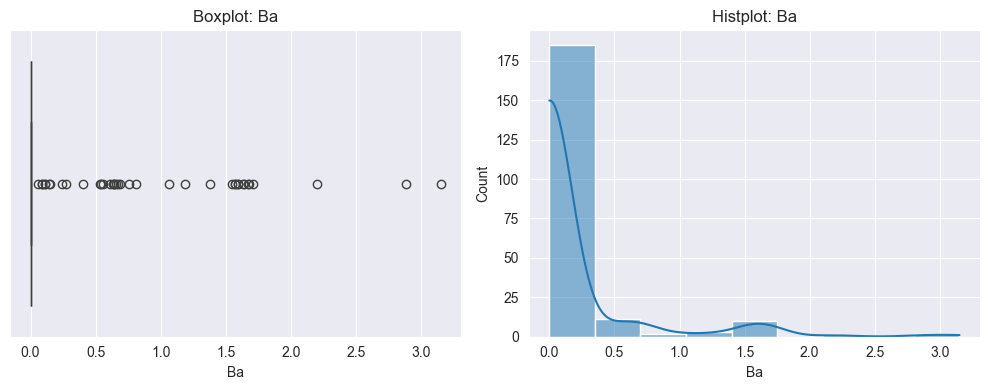

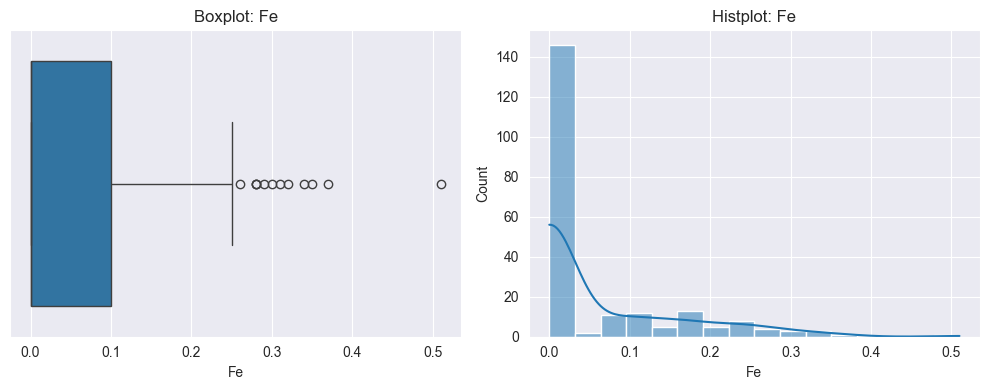

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

for col in df.drop(columns=["Type"]).columns:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot: {col}")

    plt.subplot(1, 2, 2)
    sns.histplot(df[col], kde=True)
    plt.title(f"Histplot: {col}")

    plt.tight_layout()
    plt.show()

Признаки с нормальным распределением: RI, Na, Ai, Si, Ca

Ограничиваем каждый признак межквартильным размахом 1%/99%

In [169]:
ml_model_glass(df, rfc_model, clip=True)

Accuracy score: 0.83721


KNN (LOF)

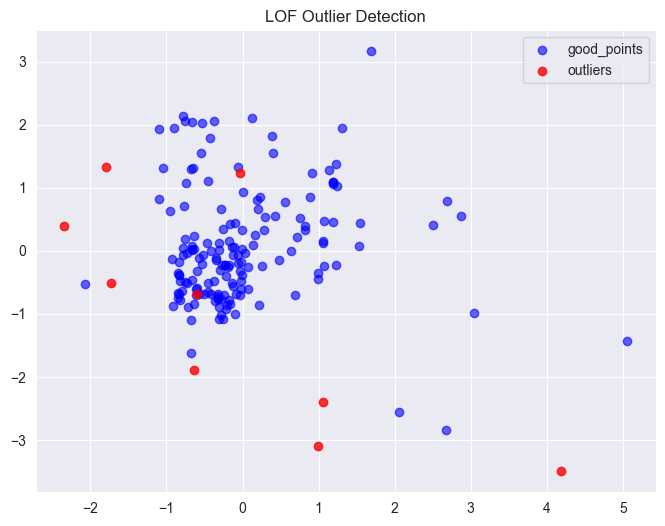

Accuracy score knn_lof: 0.86047


In [170]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

X = df.drop(columns=["Type"])
y = df["Type"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

lof = LocalOutlierFactor(n_neighbors=10, contamination=0.05)
y_pred_train_lof = lof.fit_predict(X_train_scaled)

good_points = X_train_scaled[y_pred_train_lof == 1]
outliers = X_train_scaled[y_pred_train_lof == -1]

plt.figure(figsize=(8, 6))
plt.scatter(
    good_points[:, 0], good_points[:, 1], c="blue", label="good_points", alpha=0.6
)
plt.scatter(outliers[:, 0], outliers[:, 1], c="red", label="outliers", alpha=0.8)
plt.title("LOF Outlier Detection")
plt.legend()
plt.grid(True)
plt.show()

X_train_clean_lof = X_train[y_pred_train_lof == 1]
y_train_clean_lof = y_train[y_pred_train_lof == 1]

rfc_model.fit(X_train_clean_lof, y_train_clean_lof)

y_pred_lof = rfc_model.predict(X_test)
acc = accuracy_score(y_test, y_pred_lof)
print("Accuracy score knn_lof:", round(acc, 5))

DBSCAN

In [171]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6, min_samples=1)
y_pred_train_dbscan = dbscan.fit_predict(X_train_scaled)

X_train_clean_dbscan = X_train[y_pred_train_dbscan != -1]
y_train_clean_dbscan = y_train[y_pred_train_dbscan != -1]

rfc_model.fit(X_train_clean_dbscan, y_train_clean_dbscan)
y_pred_dbscan = rfc_model.predict(X_test)
acc = accuracy_score(y_test, y_pred_dbscan)

print("Accuracy score dbscan:", round(acc, 5))

Accuracy score dbscan: 0.83721


One-class SVM

In [172]:
from sklearn.svm import OneClassSVM

ocsvm = OneClassSVM(nu=0.002, kernel="rbf", gamma="scale")
y_pred_train_ocsvm = ocsvm.fit_predict(X_train_scaled)

X_train_clean_ocsvm = X_train[y_pred_train_ocsvm != -1]
y_train_clean_ocsvm = y_train[y_pred_train_ocsvm != -1]

rfc_model.fit(X_train_clean_ocsvm, y_train_clean_ocsvm)
y_pred_ocsvm = rfc_model.predict(X_test)
acc = accuracy_score(y_test, y_pred_ocsvm)

print("Accuracy score ocsvm:", round(acc, 5))

Accuracy score ocsvm: 0.86047


Isolated Forest

In [173]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.001, random_state=42, n_estimators=100)
y_pred_train_iso_forest = iso_forest.fit_predict(X_train)

X_train_clean_iso_forest = X_train[y_pred_train_iso_forest != -1]
y_train_clean_iso_forest = y_train[y_pred_train_iso_forest != -1]

rfc_model.fit(X_train_clean_iso_forest, y_train_clean_iso_forest)
y_pred_iso_forest = rfc_model.predict(X_test)
acc = accuracy_score(y_test, y_pred_iso_forest)

print("Accuracy score iso_forest:", round(acc, 5))

Accuracy score iso_forest: 0.88372


Датасет небольшой и имеет очень малое количество аномальных объектов, как видно лучше всего справляется с очисткой Isolation Forest с указанием очень маленького процента возможных выбросов по метрике accuracy